In [103]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

from IPython.display import Image
from IPython.core.display import Image, display

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

from file_manipulations import getSortedFramePaths

from vae_conv import VariationalAutoencoder, Encoder, Decoder

In [104]:
def save_checkpoint (state, file_name="vae_lstm.pth.tar"):
    print('Saving Checkpoint')
    torch.save(state, file_name)
def load_checkpoint (checkpoint):
    print('Loading Checkpoint')
    vae.load_state_dict(checkpoint['state_dict'])

In [105]:
device = torch.device("cuda")

In [106]:
vae = VariationalAutoencoder().to(device)
vae.load_state_dict(torch.load('vae_conv.pth'))
vae.eval()

VariationalAutoencoder(
  (encoder): Encoder(
    (conv_1): Conv2d(1, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_2): Conv2d(2, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_3): Conv2d(4, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_4): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc_mu): Linear(in_features=1024, out_features=784, bias=True)
    (fc_logvar): Linear(in_features=1024, out_features=784, bias=True)
  )
  (decoder): Decoder(
    (conv_trans_1): ConvTranspose2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_trans_2): ConvTranspose2d(8, 4, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_trans_3): ConvTranspose2d(4, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (conv_trans_4): ConvTranspose2d(2, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (linear): Lin

In [107]:
batch_size = 16
device = torch.device("cuda")

In [108]:
image_path = "/media/hitsuji/Back/Dance Data/Skeleton/Advanced/"

In [109]:
composed_transform = torchvision.transforms.Compose([transforms.Resize(128), transforms.Grayscale(num_output_channels=1), transforms.ToTensor()])

In [110]:
class DanceFrameDataset(Dataset):
    def __init__(self, image_path, transforms):
        self.transforms = transforms
        self.image_path = image_path
        self.seq_len = 3
        self.image_names = getSortedFramePaths(self.image_path, ['gLH'])
    def __len__ (self):
        return len(self.image_names) - self.seq_len
    def __getitem__(self, idx):
        image_locations_x, image_location_y = self.image_names[idx:idx+self.seq_len], self.image_names[idx+self.seq_len]
        images_x = torch.empty(self.seq_len, 784)
        i = 0
        with torch.no_grad():
            for image_location in image_locations_x:
                x = (self.transforms(Image.open(image_location)) > 0.5).float().view(1, 1, 128, 128)
                images_x[i] = vae.encoder(x.to(device))[0]
                i += 1

            image_y = vae.decoder(vae.encoder((self.transforms(Image.open(image_location_y)) > 0.5).float().view(1, 1, 128, 128).to(device))[0])
        
        return images_x, image_y[0]

frame_dataset = DanceFrameDataset(image_path, composed_transform)
frame_loader = DataLoader(dataset=frame_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

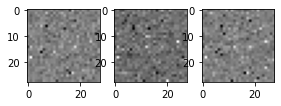

In [111]:
frames, y = next(iter(frame_loader))
for i in range(3):
    plt.subplot(1, 4, i+1)
    plt.imshow(frames[0][i].view(28, 28), cmap="gray")

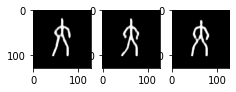

In [112]:
for i in range(3):
    with torch.no_grad():
        frames = frames.to(device)
        frames_decoded = vae.decoder(frames[0].view(3, 1, 784))
        plt.subplot(1, 5, i+1)
        plt.imshow(frames_decoded[i].cpu().view(128, 128), cmap="gray")

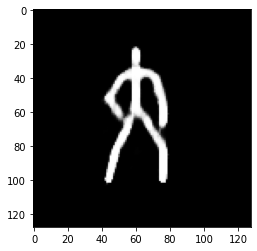

In [113]:
plt.imshow(y[0].cpu().view(128, 128), cmap="gray")

In [86]:
frames.shape

torch.Size([16, 3, 784])

In [114]:
class LSTM(nn.Module):
    def __init__(self, seq_len=3, n_features=784, n_hidden=1024, n_layers=1, output_size=3):
        super().__init__()
        self.n_features = n_features
        self.seq_len = seq_len
        self.n_hidden = n_hidden
        self.n_layers = n_layers
        
        self.l_lstm = nn.LSTM(input_size=self.n_features, hidden_size=self.n_hidden, num_layers=self.n_layers, batch_first=True)

        self.l_linear = torch.nn.Linear(self.n_hidden*self.seq_len, 784)
        

    def init_hidden(self, batch_size):
        hidden_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).to(device)
        cell_state = torch.zeros(self.n_layers,batch_size,self.n_hidden).to(device)
        self.hidden = (hidden_state, cell_state)
    
    def forward(self, x):        
        batch_size, seq_len, _ = x.size()
        
        lstm_out, self.hidden = self.l_lstm(x,self.hidden)

        x = lstm_out.contiguous().view(batch_size,-1)
        
        x = self.l_linear(x)
        return x

In [115]:
model = LSTM().to(device)
criterion = nn.BCELoss()

In [116]:
load_model = False
if load_model:
    load_checkpoint(torch.load('vae_lstm.pth.tar'))

In [117]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, verbose=True)

In [118]:
epochs = 150

In [119]:
loss_hist = []

In [ ]:
model.train()

for i in range(epochs):
    checkpoint = {'state_dict': model.state_dict()}
    save_checkpoint(checkpoint)
    for idx, (seq, label) in enumerate(frame_loader):
        optimizer.zero_grad()

        seq, label = seq.to(device), label.to(device)
        
        model.init_hidden(batch_size)
        
        y_pred = model(seq)
        
        y_pred_decoded = vae.decoder(y_pred)

        loss = criterion(y_pred_decoded, label)
        loss.backward()
        optimizer.step()
        
        loss_hist.append(loss.item())
    
        if idx % 50 == 0:
            print(f'Epoch: {i} Batch:: {idx}/{len(frame_loader)} Loss: {loss}')
    mean_loss = sum(loss_hist)/len(loss_hist)
    scheduler.step(mean_loss)

In [121]:
torch.save(model.state_dict(), 'vae_lstm.pth')

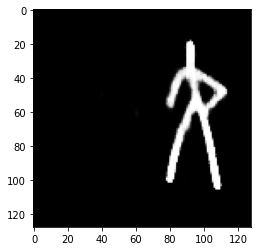

In [122]:
plt.imshow(label[0].cpu().view(128, 128), cmap="gray")

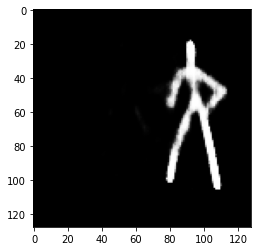

In [123]:
plt.imshow(y_pred_decoded[0].detach().cpu().view(128, 128), cmap="gray")

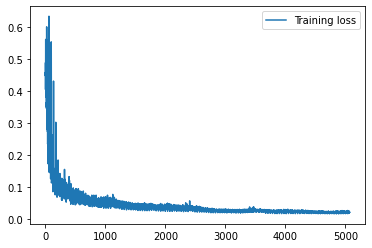

In [124]:
plt.plot(loss_hist, label="Training loss")
plt.legend()
plt.show()

In [ ]:
# Testing the Model Visually

In [125]:
seq_num = 10

In [126]:
frames, y = next(iter(frame_loader))
frames, y = frames.to(device), y.to(device)

In [127]:
frames.shape

torch.Size([16, 3, 784])

In [128]:
with torch.no_grad():
    model.init_hidden(batch_size)
    pred_y = vae.decoder(model(frames))
    print(pred_y.shape)

torch.Size([16, 1, 128, 128])


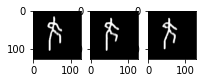

In [129]:
dec_seq = vae.decoder(frames[seq_num].view(3, 1, 784))

for i in range(3):
    with torch.no_grad():
        plt.subplot(1, 6, i+1)
        plt.imshow(dec_seq[i].view(128, 128).cpu(), cmap="gray")